In [1]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq


def open_gff3_files(path:str= ''):
    with open(path, 'r') as infile:
        LINES = []
        for line in infile:
            LINES.append(line[:].split('\t'))
        LINES = LINES[1:]
    
    return LINES


def tidy_up_gff(lst_of_gff:list):
    signal_peptides = {}
    list_of_peptides = []

    for peptide in lst_of_gff:
        signal_peptides['gene'] = peptide[0][:19]
        signal_peptides['start_pos'] = int(peptide[3])-1
        signal_peptides['end_pos']= int(peptide[4])-1
        signal_peptides['signal_peptide_likelyhood']= peptide[5]
        list_of_peptides.append(signal_peptides)
        signal_peptides = {'gene':'', 'start_pos':'', 'end_pos':'','signal_peptide_likelyhood': '' }

    return list_of_peptides



def dict_of_signal_peptides(path:str= ''):
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)

    return dict_of_signal_peptides


def read_gff_to_pd(path:str= ''): 
    
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    df = pd.DataFrame.from_records(dict_of_signal_peptides)
    
    return df


def read_gff_to_pd(path:str= ''): 
    
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    df = pd.DataFrame.from_records(dict_of_signal_peptides)
    
    return df

def cross_ref_with_genome(list_of_peptides:list ,all_proteins:list ):
    
    signal_peptide_seqs = []
    pure_sequences = []

    for signal_peptide in list_of_peptides:
        for seqrecord in all_proteins:
            if signal_peptide['gene'] in seqrecord.id:             
                seq = SeqRecord(
                    Seq(seqrecord.seq[signal_peptide['start_pos']:signal_peptide['end_pos']]), 

                    id=seqrecord.id,
                    name=seqrecord.name,
                    description="signal_peptide predicted by signalP")


                signal_peptide_seqs.append(seq)
                pure_sequences.append(str(seqrecord.seq[signal_peptide['start_pos']:signal_peptide['end_pos']]))


    return pure_sequences

# 00_Data_processing

## Introduction
The objective of this project is to analyze the signal peptides of the A.oryzae genome. The first step is to download the genome and partition it into 5000 bits. These bits will then be uploaded to SignalP, a tool for predicting signal peptides. The program will retrieve the signal peptides from SignalP and perform an analysis of different regions. Finally, the project will create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

### Objective: 


- Download the A.oryzae genome
- Partition the genome into 5000 bits
- Upload the partitioned genome to SignalP
- Retrieve signal peptides from the SignalP analysis
- Analyze different regions of the signal peptides
- Create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

In [2]:
path_to_file = '../data/00_All_proteins_and_partitions_Aoryzae_and_/FungiDB-59_AoryzaeRIB40_AnnotatedProteins.fasta'  

# Open file with "with" statement to avoid problems with access 
proteins = []

with open(path_to_file, mode='r') as handle:
    for record in SeqIO.parse(handle, 'fasta'):

        # Extract individual parts of the FASTA record
        identifier = record.id
        description = record.description
        sequence = record.seq
        # append
        proteins.append(record)

In [5]:
len(proteins)

12090

### Partitioning the proteins into 5000 long fasta files

In [6]:
partition1 = proteins[0:5000]
len(partition1)

5000

In [7]:
partition2 = proteins[5000:10000]
len(partition2)

5000

In [8]:
partition3 = proteins[10000:]
len(partition3)


2090

In [9]:
all_partitions = [[partition1]+[partition2]+[partition3]]
all_partitions = [partition1+partition2+partition3]

len(all_partitions)

1

In [10]:
with open(f"../data/00_All_proteins_and_partitions_Aoryzae_and_/partition1.fasta", "w") as output_handle:
    SeqIO.write(partition1, output_handle, "fasta")
with open(f"../data/00_All_proteins_and_partitions_Aoryzae_and_/partition2.fasta", "w") as output_handle:
    SeqIO.write(partition2, output_handle, "fasta")
with open(f"../data/00_All_proteins_and_partitions_Aoryzae_and_/partition3.fasta", "w") as output_handle:
    SeqIO.write(partition3, output_handle, "fasta")

These partitions have been sent to SignalP and run on their servers. 

### Examining SignalP output


In signalP with the following parameters were used: 

Organism : Eukarya
Output format: Short output (no figures)
Model mode: Slow
 


Output from SignalP are shown below : gff files are just a text file. So we can parse it like a normal text file:

In [11]:
partition1_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition2 /output (1).gff3')
partition3_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition3/output (2).gff3')

all_signal_peptides_df = pd.concat([partition1_signal_peptides, partition2_signal_peptides, partition3_signal_peptides])
all_signal_peptides_df

,gene,start_pos,end_pos,signal_peptide_likelyhood
0,AO090005000016-T-p1,0,23,0.99980325
1,AO090005000029-T-p1,0,23,0.99983543
2,AO090005000042-T-p1,0,23,0.99984324
3,AO090005000053-T-p1,0,41,0.8548089
4,AO090005000059-T-p1,0,18,0.9998212
...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604
197,AO090103000487-T-p1,0,19,0.99971014
198,AO090103000493-T-p1,0,17,0.99979144
199,AO090701000994-T-p1,0,18,0.99984515


In [12]:
partition1_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition2 /output (1).gff3')
partition3_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition3/output (2).gff3')
all_signal_peptides = partition1_signal_peptides +partition2_signal_peptides+ partition3_signal_peptides

### Cross reference with the genome to extract the signal peptides

In [61]:
pure_signal_peptide = cross_ref_with_genome(all_signal_peptides, proteins)
print(pure_signal_peptide[0])
print(len(pure_signal_peptide[0]))

MAPSHSFMLFLSVICTHLCSLVV
23


In [14]:
all_signal_peptides_df['sequence'] = pure_signal_peptide
all_signal_peptides_df

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV
1,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD
2,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY
3,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL
4,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL
...,...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS
197,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF
198,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT
199,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ


In [15]:
list_of_SPs = list(all_signal_peptides_df['sequence'])

Lets write all the motifs to a csv file:

In [16]:
with open('../data/02_all_signal_peptides/all_SPs.txt', 'w') as outhandle: 
    for i in range(len(list_of_SPs)): 
        outhandle.write('>'+str(i)+'\n'+list_of_SPs[i]+'\n')

In [17]:
### Statistics on lenght: 
mean_length = all_signal_peptides_df["end_pos"].mean()
mean_length 


21.388312912346844

In [18]:
### Statistics on lenght: 
median = all_signal_peptides_df["end_pos"].median()
median 

20.0

In [19]:
### Statistics on lenght: 
describe = all_signal_peptides_df["end_pos"].describe()
describe 

count    1061.000000
mean       21.388313
std         6.170687
min        12.000000
25%        18.000000
50%        20.000000
75%        24.000000
max        68.000000
Name: end_pos, dtype: float64

Lets get the differenct regions of the signal peptides: 

##  Regions of Signal peptides

In [20]:
partition1_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition1/region_output.gff3')
partition2_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition2 /region_output (1).gff3')
partition3_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition3/region_output (2).gff3')


In [21]:
all_signal_peptide_regions = pd.concat([partition1_signal_peptides_regions,partition2_signal_peptides_regions,partition3_signal_peptides_regions])
all_signal_peptide_regions.columns = ['gene',	'start_pos_region','end_pos_region','region']
all_signal_peptide_regions

,gene,start_pos_region,end_pos_region,region
0,AO090005000016-T-p1,0,3,.
1,AO090005000016-T-p1,4,20,.
2,AO090005000016-T-p1,21,23,.
3,AO090005000029-T-p1,0,1,.
4,AO090005000029-T-p1,2,12,.
...,...,...,...,...
598,AO090701000994-T-p1,2,12,.
599,AO090701000994-T-p1,13,18,.
600,AO090701001287-T-p1,0,2,.
601,AO090701001287-T-p1,3,17,.


In [22]:
(len(all_signal_peptide_regions)/3)

1061.0

In [23]:
# every region is the same N, H, C. will just append a long list 
regions = ['n-region', 'h-region', 'c-region']* int((len(all_signal_peptide_regions)/3))
all_signal_peptide_regions['region'] = regions

In [24]:
merged = pd.merge(all_signal_peptides_df,all_signal_peptide_regions , on=["gene"])
merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region
1,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,4,20,h-region
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region
4,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,2,12,h-region
...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,2,12,h-region
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region
3180,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,0,2,n-region
3181,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,3,17,h-region


In [25]:
merged['region_seq'] = ''

In [113]:
list_of_seqs = []
for index, row in merged.iterrows():
    if row['start_pos_region'] == 0: 
        start = int(row['start_pos_region'])
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop])
    else: 
        start = int(row['start_pos_region'])-1
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop]) 
    
merged['region_seq'] = list_of_seqs

### Biochemical analysis

In [115]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

list_of_kyle_d = []
isoelectric_point =[]
charge = []

for index, row in merged.iterrows():
    protein = ProteinAnalysis(str(row['region_seq']))
    list_of_kyle_d.append(protein.gravy())
    isoelectric_point.append(protein.isoelectric_point())
    charge.append(protein.charge_at_pH(7.6))

merged['Kyte_Doolittle_hydrophobicity'] = list_of_kyle_d
merged['isoelectric_point'] = isoelectric_point
merged['charge_at_ph7'] = charge

In [127]:
len('SHSFMLFLSVICTHLCS')

17

In [126]:
protein = ProteinAnalysis(str('SHSFMLFLSVICTHLCS'))
protein.gravy()

1.311764705882353

In [116]:
merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,isoelectric_point,charge_at_ph7
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region,MAP,7.000000e-01,5.275022,-0.799151
1,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,4,20,h-region,SHSFMLFLSVICTHLCS,1.311765e+00,6.650014,-0.853493
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region,LVV,4.066667e+00,5.525000,-0.557223
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region,M,1.900000e+00,5.275022,-0.799151
4,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,2,12,h-region,HLRNIVIALAA,1.363636e+00,9.756532,0.466164
...,...,...,...,...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,2,12,h-region,RLLLIAPLFSA,1.745455e+00,9.750021,0.442738
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region,VSYGAQ,1.480297e-16,5.494364,-0.594952
3180,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,0,2,n-region,ML,2.850000e+00,5.275022,-0.799151
3181,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,3,17,h-region,FYRAFGGLLCFLYAC,1.366667e+00,8.045155,0.358234


#### Grouping the regions 

In [128]:
n_region = merged.groupby("region")
n_region = n_region.get_group('n-region')


h_region = merged.groupby("region")
h_region = h_region.get_group('h-region')

c_region = merged.groupby("region")
c_region = c_region.get_group('c-region')

In [129]:
c_region

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,isoelectric_point,charge_at_ph7
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region,LVV,4.066667e+00,5.525000,-0.557223
5,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,13,23,c-region,TAVASPVDLQD,2.000000e-01,4.050028,-2.856209
8,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,21,23,c-region,LSY,5.666667e-01,5.524318,-0.561188
11,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL,36,41,c-region,SPTVAL,1.116667e+00,5.240009,-0.823772
14,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL,16,18,c-region,LTL,2.300000e+00,5.525000,-0.557223
...,...,...,...,...,...,...,...,...,...,...,...,...
3170,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS,16,19,c-region,LPCS,9.750000e-01,5.518123,-0.595509
3173,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF,14,19,c-region,FGNSVF,8.500000e-01,5.525000,-0.557223
3176,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT,14,17,c-region,LGVT,1.725000e+00,5.525000,-0.557223
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region,VSYGAQ,1.480297e-16,5.494364,-0.594952


### Plotting hydrophicity per regions

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'c-region')

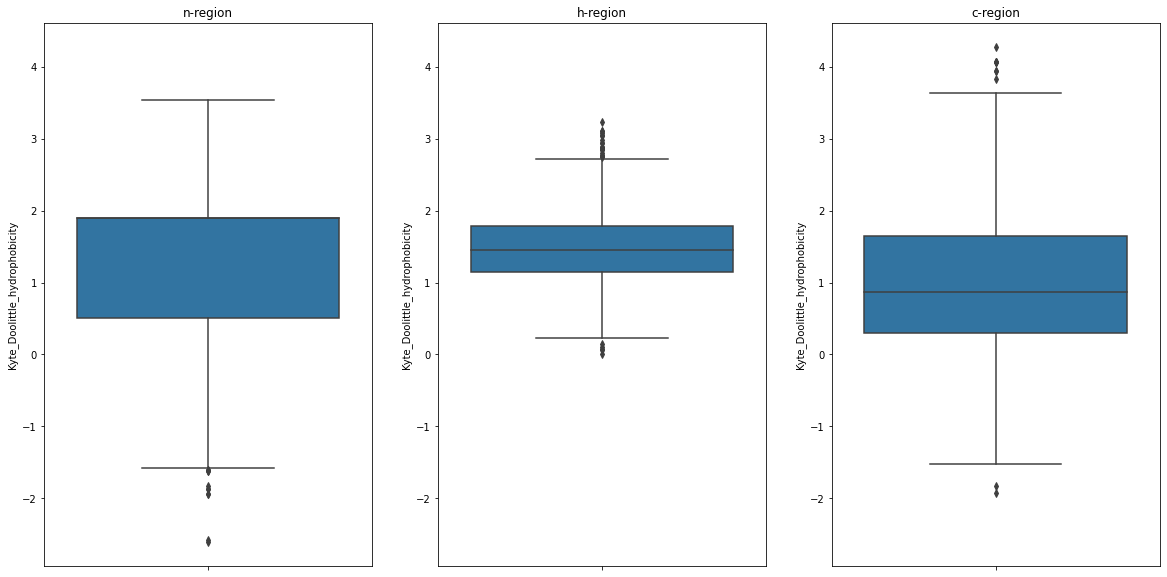

In [131]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(1,3,1)
ax1 = sns.boxplot(y=n_region["Kyte_Doolittle_hydrophobicity"], orient='vertical')


plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["Kyte_Doolittle_hydrophobicity"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["Kyte_Doolittle_hydrophobicity"], orient='Vertical')
plt.title('c-region')



### Plotting isoelectric_point per regions

Text(0.5, 1.0, 'c-region')

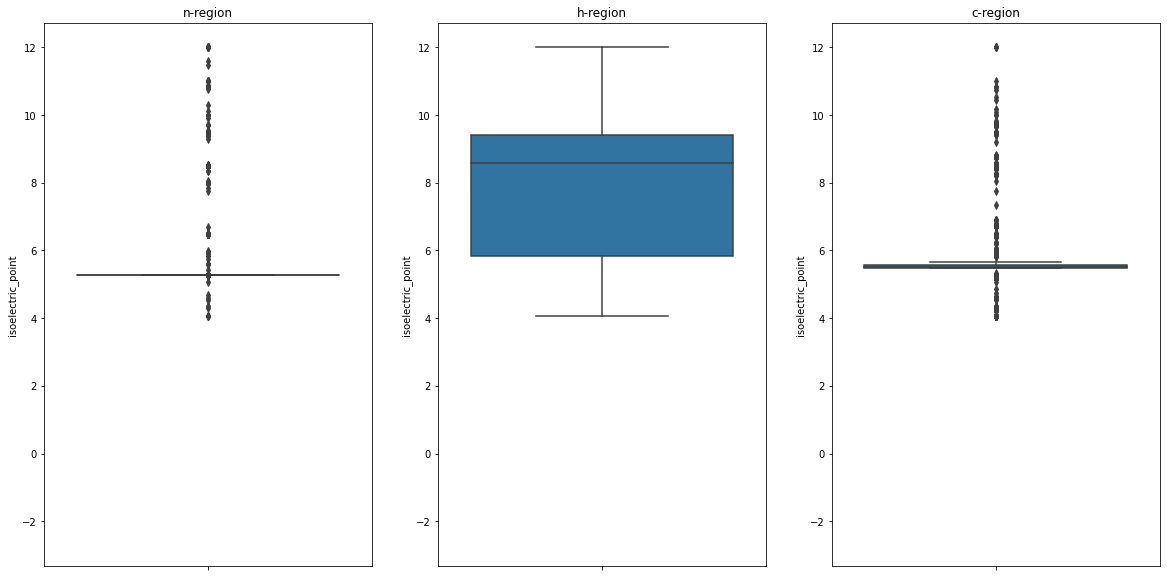

In [132]:

plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1, sharex=ax1, sharey=ax1)
ax1 = sns.boxplot(y=n_region["isoelectric_point"], orient='vertical')


plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["isoelectric_point"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["isoelectric_point"], orient='Vertical')
plt.title('c-region')


### Plotting charge_at_ph 7.6 per regions
The following article mentions that physiological ph is 7.6 for Aspergillus
ref : https://pubmed.ncbi.nlm.nih.gov/12135488/

Text(0.5, 1.0, 'c-region')

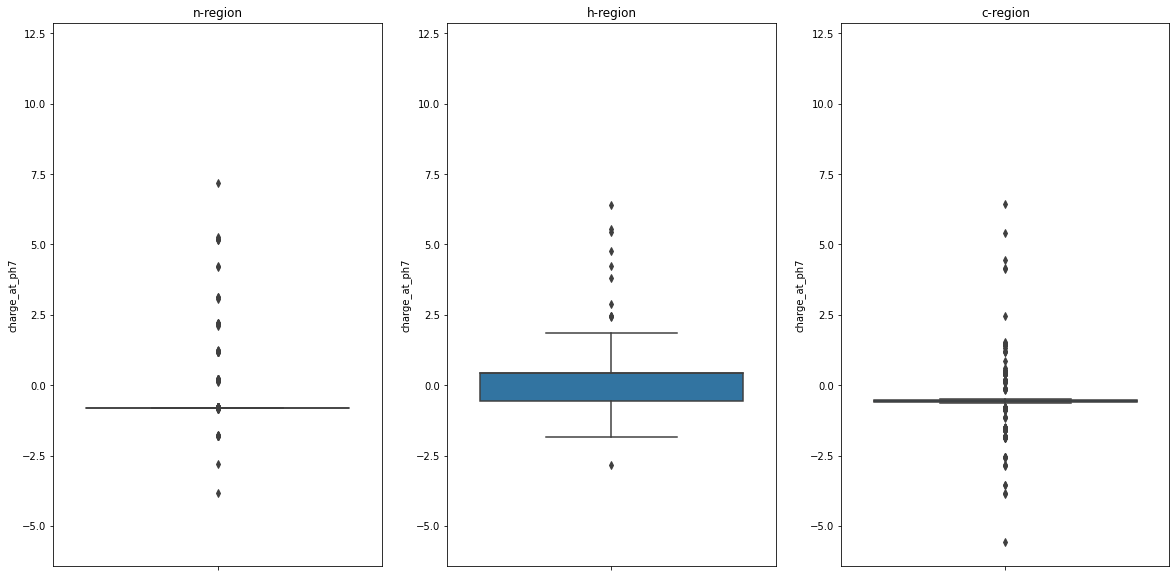

In [133]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1, sharex=ax1, sharey=ax1)
ax1 = sns.boxplot(y=n_region["charge_at_ph7"], orient='vertical')

plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["charge_at_ph7"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["charge_at_ph7"], orient='Vertical')
plt.title('c-region')

## PWM with signal peptides with all lenghts

Ok, so we know from the statistics above that 460+ signal peptides are exactly 20 amino acids long. We want to train ML algoriths on all sizes of signal peptides so lets try to append dashes to signal peptides that are shorter than the longest signal peptide

In [134]:
longest_signalP = 63

In [135]:
instances = []
for sp in list_of_SPs: 
    if len(sp) < longest_signalP:
        difference = longest_signalP - len(sp)
        instances.append(Seq(sp+ '-'*difference))

In [136]:
instances[:10]

[Seq('MAPSHSFMLFLSVICTHLCSLVV-------------------------------...---'),
 Seq('MHLRNIVIALAATAVASPVDLQD-------------------------------...---'),
 Seq('MKASFISRLLSLTAFAISSNLSY-------------------------------...---'),
 Seq('MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL-------------...---'),
 Seq('MHLQATLAVGLSLLGLTL------------------------------------...---'),
 Seq('MFSTMTPSLSKLVALSLFLGTAL-------------------------------...---'),
 Seq('MRIFSSIFAVANVLSLSTGRVIP-------------------------------...---'),
 Seq('MRSVSLFLWGLAPLLAS-------------------------------------...---'),
 Seq('MKSILYYTSCFIAVLGTVN-----------------------------------...---'),
 Seq('MGRQTPVYRAAQTCILGLVLLSFAS-----------------------------...---')]

In [137]:
from Bio import motifs

m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY-")
m.consensus

Seq('MKLLLLLLLLLLLLAAA-------------------------------------...---')

In [138]:
df = pd.DataFrame(m.counts)
df

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,74,2,3,2,34,23,68,40,221,90,...,24,30,62,205,36,20,56,15,30,0
2,47,8,7,8,162,50,21,53,20,202,...,22,56,22,57,139,57,64,27,24,0
3,61,2,5,5,95,21,17,68,62,186,...,36,44,46,60,173,106,23,11,28,0
4,77,5,5,8,58,34,21,82,57,165,...,44,43,39,48,147,102,46,25,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,1056
59,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1057
60,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1057
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1059


In [139]:
# getting the prevalence of each AA on each position 
df_pwn = pd.DataFrame(m.pwm)
df_pwn.to_csv('../data/02_all_signal_peptides/df_pwn_68_positions.csv', index_label=False )
df_pwn

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.069877,0.001889,0.002833,0.001889,0.032106,0.021719,0.064212,0.037771,0.208687,0.084986,...,0.022663,0.028329,0.058546,0.193579,0.033994,0.018886,0.052880,0.014164,0.028329,0.000000
2,0.044381,0.007554,0.006610,0.007554,0.152975,0.047214,0.019830,0.050047,0.018886,0.190746,...,0.020774,0.052880,0.020774,0.053824,0.131256,0.053824,0.060434,0.025496,0.022663,0.000000
3,0.057602,0.001889,0.004721,0.004721,0.089707,0.019830,0.016053,0.064212,0.058546,0.175637,...,0.033994,0.041549,0.043437,0.056657,0.163362,0.100094,0.021719,0.010387,0.026440,0.000000
4,0.072710,0.004721,0.004721,0.007554,0.054769,0.032106,0.019830,0.077432,0.053824,0.155807,...,0.041549,0.040604,0.036827,0.045326,0.138810,0.096317,0.043437,0.023607,0.032106,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001889,0.000944,0.000000,0.000000,0.000000,0.997167
59,0.000000,0.000000,0.000000,0.000944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000944,0.000000,0.000000,0.000000,0.998111
60,0.000944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000944,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.998111
61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [140]:
import logomaker as lm

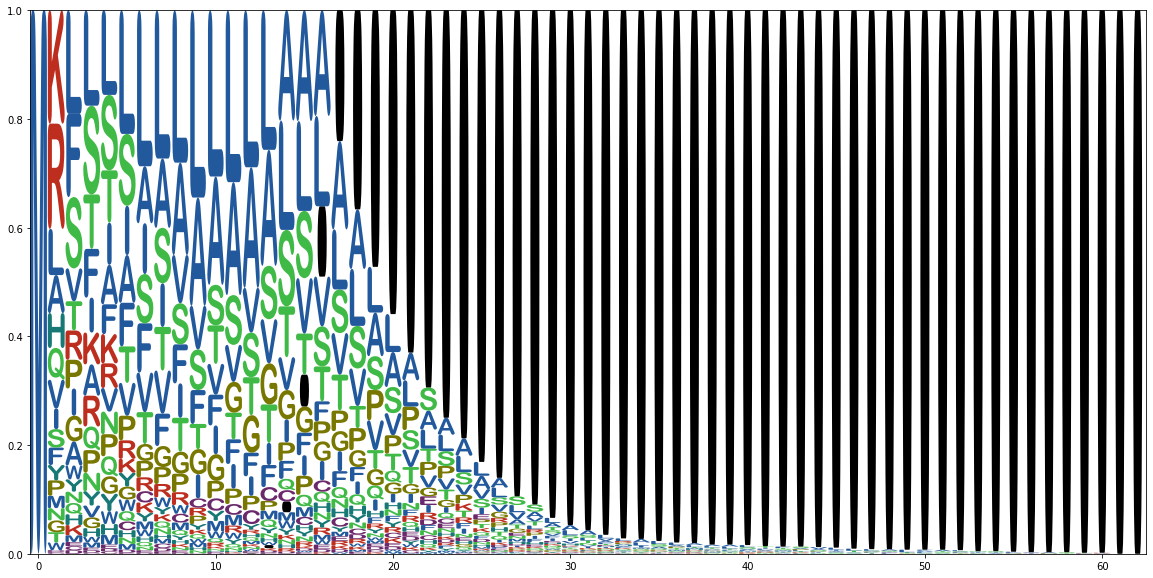

In [141]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(20,10))

## PWM with signal peptides of 20 aa lenght

ok so the following only works if you use the same length of sequences so we have to trim them. Not a fan of trimming. we will have to find a way around this: 

In [142]:
instances = []
for sp in list_of_SPs: 
    if len(sp) > 20: 
        instances.append(Seq(sp[:20]))
    else: 
        continue

In [143]:
from Bio import motifs

m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY-")
m.consensus

Seq('MKLSSLLLLLLLLLLLLALA')

In [144]:
df = pd.DataFrame(m.counts)
df_pwn = pd.DataFrame(m.pwm)
df_pwn.to_csv('../data/02_all_signal_peptides/df_pwn_20_positions.csv')
df_pwn

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.106610,0.004264,0.006397,0.004264,0.029851,0.038380,0.061834,0.036247,0.170576,0.066098,...,0.021322,0.040512,0.046908,0.151386,0.051173,0.023454,0.074627,0.021322,0.023454,0.0
2,0.046908,0.004264,0.012793,0.014925,0.138593,0.059701,0.029851,0.057569,0.019190,0.164179,...,0.029851,0.055437,0.019190,0.055437,0.144989,0.051173,0.036247,0.019190,0.021322,0.0
3,0.044776,0.002132,0.010661,0.006397,0.098081,0.025586,0.014925,0.053305,0.063966,0.144989,...,0.036247,0.051173,0.038380,0.072495,0.164179,0.102345,0.019190,0.006397,0.034115,0.0
4,0.053305,0.006397,0.006397,0.008529,0.061834,0.029851,0.017058,0.076759,0.059701,0.110874,...,0.057569,0.042644,0.038380,0.063966,0.164179,0.100213,0.036247,0.014925,0.025586,0.0
5,0.072495,0.017058,0.010661,0.004264,0.070362,0.029851,0.017058,0.078891,0.038380,0.172708,...,0.014925,0.053305,0.031983,0.046908,0.153518,0.085288,0.042644,0.014925,0.027719,0.0
6,0.074627,0.029851,0.004264,0.002132,0.085288,0.044776,0.021322,0.076759,0.034115,0.236674,...,0.008529,0.036247,0.017058,0.049041,0.093817,0.051173,0.072495,0.017058,0.021322,0.0
7,0.074627,0.010661,0.012793,0.010661,0.061834,0.031983,0.008529,0.070362,0.027719,0.223881,...,0.017058,0.036247,0.025586,0.053305,0.106610,0.106610,0.072495,0.021322,0.017058,0.0
8,0.149254,0.017058,0.004264,0.010661,0.061834,0.044776,0.012793,0.061834,0.012793,0.238806,...,0.010661,0.036247,0.012793,0.053305,0.095949,0.053305,0.076759,0.014925,0.010661,0.0
9,0.170576,0.014925,0.002132,0.000000,0.057569,0.051173,0.010661,0.038380,0.017058,0.307036,...,0.010661,0.021322,0.014925,0.034115,0.074627,0.049041,0.083156,0.010661,0.019190,0.0


In [145]:
import logomaker as lm

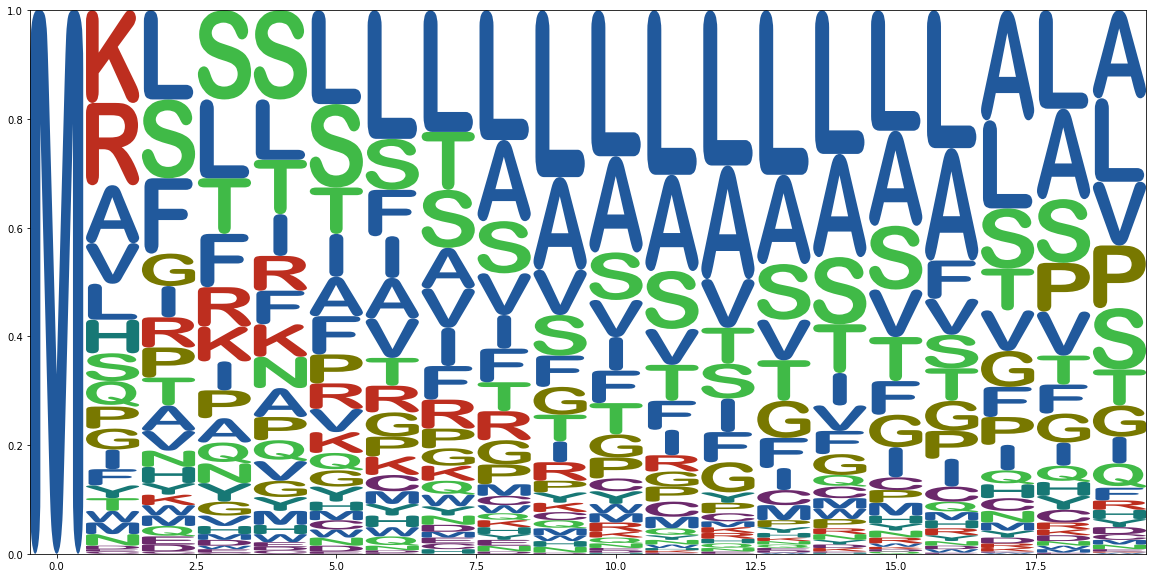

In [146]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(20,10))

In [147]:
df_pwn.describe()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0
mean,0.131130,0.016525,0.006503,0.004478,0.059808,0.044030,0.015885,0.053305,0.025267,0.203092,...,0.015352,0.040938,0.021429,0.035501,0.102665,0.065672,0.064286,0.010448,0.017377,0.0
std,0.064822,0.009532,0.004346,0.003968,0.027908,0.016707,0.013564,0.017866,0.038877,0.082799,...,0.013082,0.026156,0.013511,0.035391,0.040077,0.025963,0.026911,0.007415,0.008193,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.074094,0.009595,0.004264,0.002132,0.053305,0.031450,0.008529,0.045842,0.005864,0.159915,...,0.008529,0.022921,0.012260,0.010661,0.084222,0.052772,0.045842,0.005330,0.010661,0.0
50%,0.163113,0.017058,0.006397,0.004264,0.058635,0.044776,0.014925,0.054371,0.010661,0.222814,...,0.010661,0.037313,0.019190,0.023454,0.106610,0.066098,0.072495,0.008529,0.018124,0.0
75%,0.176972,0.023454,0.010661,0.004797,0.063966,0.055970,0.018124,0.061834,0.029318,0.265458,...,0.018124,0.051173,0.030384,0.053305,0.118870,0.082090,0.077825,0.017058,0.023454,0.0
max,0.208955,0.029851,0.012793,0.014925,0.138593,0.068230,0.061834,0.078891,0.170576,0.307036,...,0.057569,0.115139,0.046908,0.151386,0.164179,0.106610,0.117271,0.021322,0.034115,0.0


In [148]:
len(list_of_top_aa_per_position)

19

## PWM of signal peptides found from proteomics data

In [244]:
proteomics_df = pd.read_excel('../data/03_proteomics_data/20221124_FJ_E1200_MWN_15cm_140min_500ng_#1572_proteins.xlsx')

In [245]:
pure_peptides = merged.drop_duplicates(subset=['gene'])
pure_peptides

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,isoelectric_point,charge_at_ph7
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region,MAP,0.700,5.275022,-0.799151
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region,M,1.900,5.275022,-0.799151
6,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,0,1,n-region,M,1.900,5.275022,-0.799151
9,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL,0,25,n-region,MGLFLTALGALSSVNVLYSRGRMPL,0.868,10.834379,1.196804
12,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL,0,1,n-region,M,1.900,5.275022,-0.799151
...,...,...,...,...,...,...,...,...,...,...,...,...
3168,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS,0,2,n-region,MK,-1.000,8.500108,0.196884
3171,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF,0,2,n-region,MT,0.600,5.275022,-0.799151
3174,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT,0,1,n-region,M,1.900,5.275022,-0.799151
3177,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,0,1,n-region,M,1.900,5.275022,-0.799151


In [246]:
list_of_proteins_found_in_supernatant = proteomics_df['Accession'].to_list()

In [247]:
predicted_SPs = all_signal_peptides_df['gene'].to_list()

In [248]:
list_of_acc_real_signal_peptides = []
for signal_peptide in predicted_SPs: 
    if signal_peptide in list_of_proteins_found_in_supernatant: 
        list_of_acc_real_signal_peptides.append(signal_peptide)
print(len(list_of_real_signal_peptides))

256


In [249]:
sequence_SPs_real = []
for index, row in pure_peptides.iterrows():
    if row['gene'] in list_of_real_signal_peptides: 
        sequence_SPs_real.append(row['sequence'])
print(len(sequence_SPs_real))

256


what is the longest observed signal peptide? 

In [297]:
res = max(sequence_SPs_real, key = len)
len(res)

68

In [298]:
longest_signalP = int(len(res))

In [304]:
instances = []
for sp in sequence_SPs_real: 
    if len(sp) < longest_signalP:
        difference = longest_signalP - len(sp)
        sequence = sp + ('-'*difference)
        instances.append(sequence)
    else: 
        instances.append(sp)

In [306]:
instances

['MHLRNIVIALAATAVASPVDLQD---------------------------------------------',
 'MKASFISRLLSLTAFAISSNLSY---------------------------------------------',
 'MFSTMTPSLSKLVALSLFLGTAL---------------------------------------------',
 'MHLSSFSLLALGAATAN---------------------------------------------------',
 'MKGLYLTAALFGASST----------------------------------------------------',
 'MRLITRWIPLANALASTMPVQVV---------------------------------------------',
 'MKFISVIALLAPTVL-----------------------------------------------------',
 'MKFHLWAVALASALCVQ---------------------------------------------------',
 'MPSLSTLKLGAFLGLAAIAPSIE---------------------------------------------',
 'MKFNAVALTLATAGSLVA--------------------------------------------------',
 'MSLPSFLKWSAMAALMAQLCT-----------------------------------------------',
 'MRGAFLAAAAAVAGTAM---------------------------------------------------',
 'MRAFESVFAAIACLAHIGMTD-----------------------------------------------',
 'MRISQICTVLSTVTSAVAVGVNPLPAP----------------------

In [307]:
m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY-")
m.consensus

Seq('MKLSSLLLLLLLLLAAA-------------------------------------...---')

In [308]:
df_pwn = pd.DataFrame(m.pwm)
df_pwn

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.070312,0.000000,0.003906,0.003906,0.035156,0.000000,0.062500,0.035156,0.234375,0.078125,...,0.011719,0.031250,0.070312,0.214844,0.031250,0.007812,0.046875,0.015625,0.015625,0.000000
2,0.042969,0.000000,0.003906,0.007812,0.179688,0.058594,0.000000,0.050781,0.015625,0.210938,...,0.023438,0.027344,0.023438,0.066406,0.140625,0.050781,0.066406,0.007812,0.015625,0.000000
3,0.070312,0.000000,0.003906,0.000000,0.097656,0.035156,0.015625,0.046875,0.062500,0.167969,...,0.031250,0.042969,0.058594,0.042969,0.179688,0.085938,0.015625,0.011719,0.019531,0.000000
4,0.109375,0.007812,0.007812,0.007812,0.035156,0.027344,0.015625,0.066406,0.066406,0.136719,...,0.046875,0.035156,0.046875,0.015625,0.167969,0.078125,0.046875,0.019531,0.046875,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003906,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992188
64,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996094
65,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996094
66,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996094


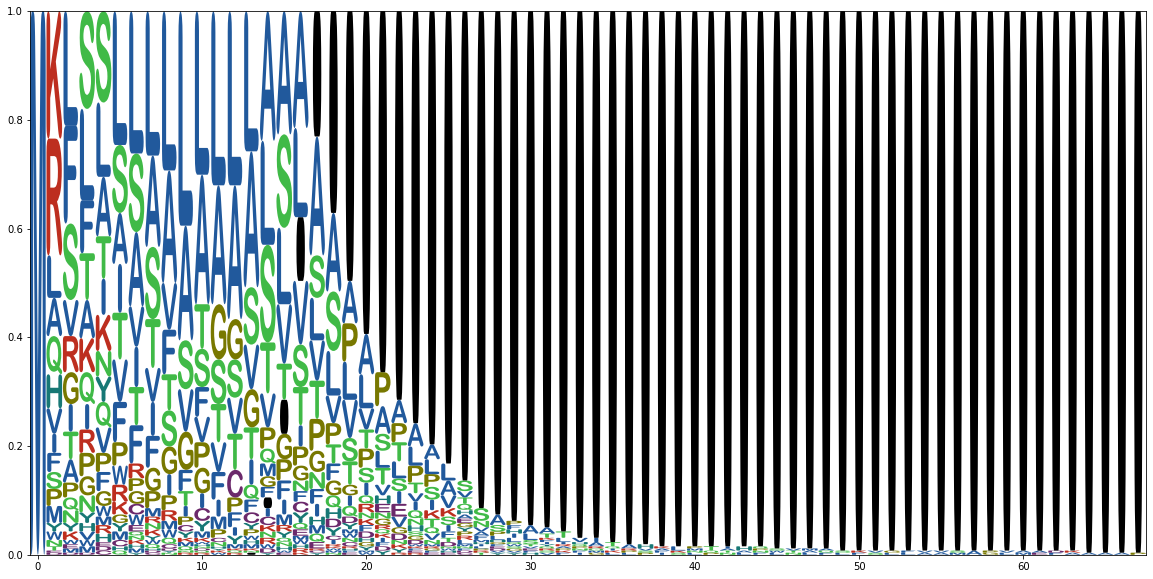

In [309]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(20,10))

We migth want to limit the length to around 30 so lets make another df

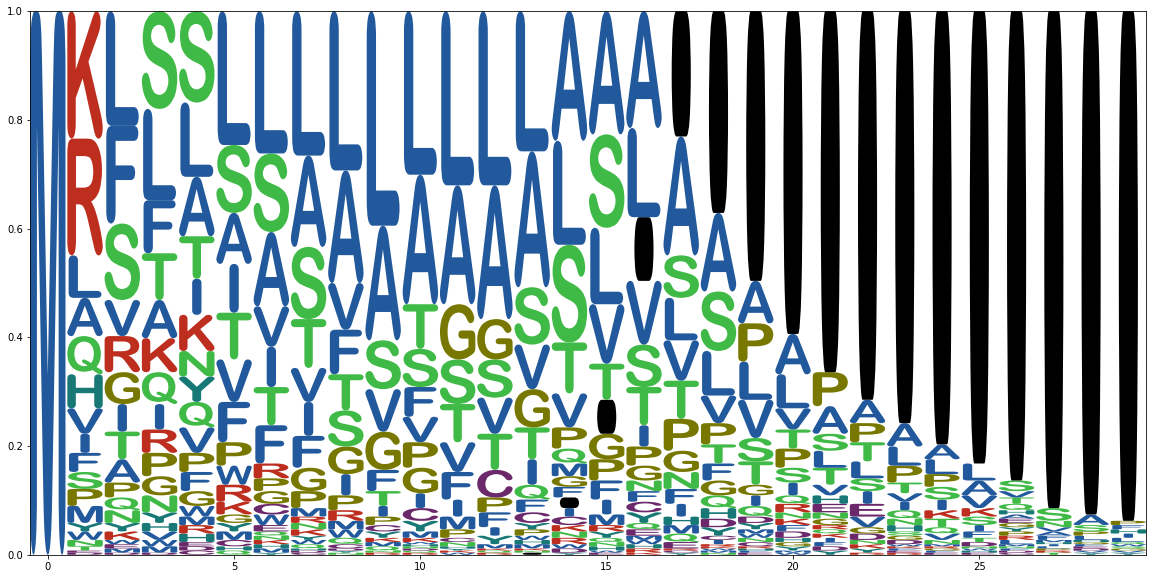

In [312]:
df_pwn_30 = df_pwn[0:30]
logo = lm.Logo(df_pwn_30, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(20,10))

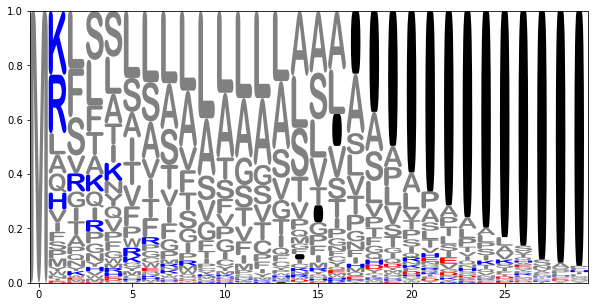

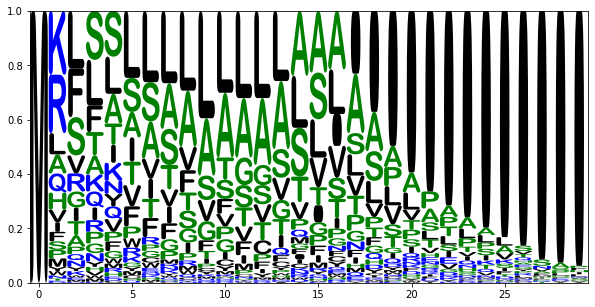

In [314]:
#### We can color for charge and hydrophobicity

df_pwn_30 = df_pwn[0:30]
logo = lm.Logo(df_pwn_30, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='charge',
               figsize=(10,5))

df_pwn_30 = df_pwn[0:30]
logo = lm.Logo(df_pwn_30, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='hydrophobicity',
               figsize=(10,5))

# Combinatorial explosion

In order to engineer signal peptides, a prediction table must be generated to identify the specific amino acid sequences that are most likely to function as signal peptides. However, the number of possible combinations of the 20 amino acids that make up proteins is extremely large. For example, if a signal peptide consists of just 20 amino acids, there are 20^20 (or approximately 2 x 10^13) possible combinations. This large number of possibilities makes it difficult to predict which sequences will function as signal peptides and which will not. To overcome this challenge, computational methods must be applied. In the next notbook we well show such a method with the use of machine learning. 

An example of how quickly this happens is visualized below:

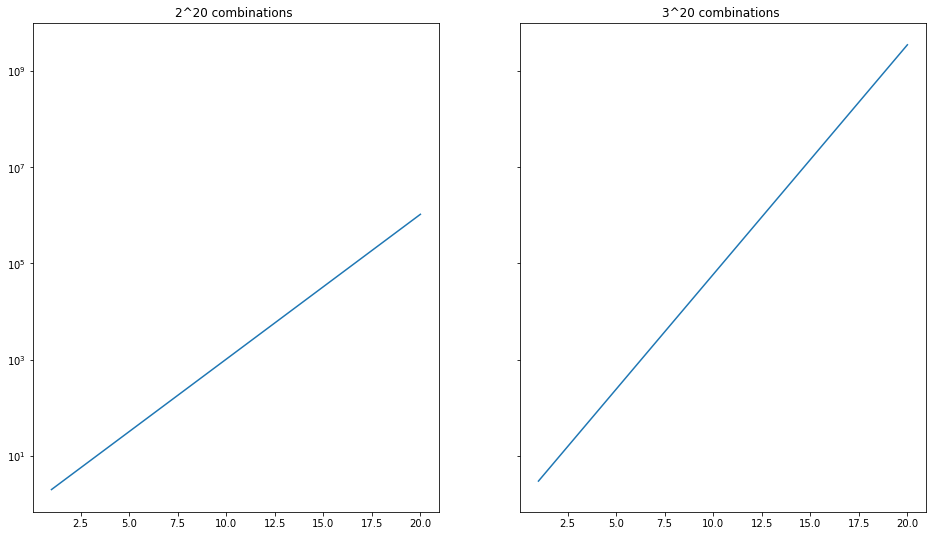

In [51]:
import matplotlib.pyplot as plt

## Generating 3^20 combinations 
data_points1 = []
index1 = []

for i in range(1,21): 
    data_points1.append(2**i)
    index1.append(i)
    
## Generating 2^20 combinations 
data_points2 = []
index2 = []
for i in range(1,21): 
    data_points2.append(3**i)
    index2.append(i)

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,9))

ax1.plot(index1, data_points1)
ax1.set_title('2^20 combinations ')
ax2.plot(index2,data_points2)
ax2.set_title('3^20 combinations ')
plt.yscale("log")


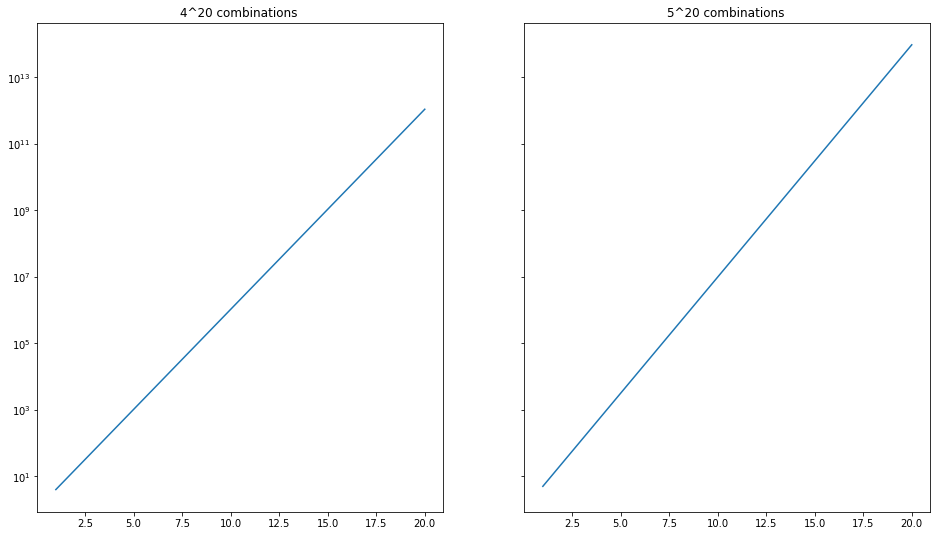

In [52]:
import matplotlib.pyplot as plt

## Generating 3^20 combinations 
data_points1 = []
index1 = []

for i in range(1,21): 
    data_points1.append(4**i)
    index1.append(i)
    
## Generating 2^20 combinations 
data_points2 = []
index2 = []
for i in range(1,21): 
    data_points2.append(5**i)
    index2.append(i)

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,9))

ax1.plot(index1, data_points1)
ax1.set_title('4^20 combinations ')
ax2.plot(index2,data_points2)
ax2.set_title('5^20 combinations ')
plt.yscale("log")

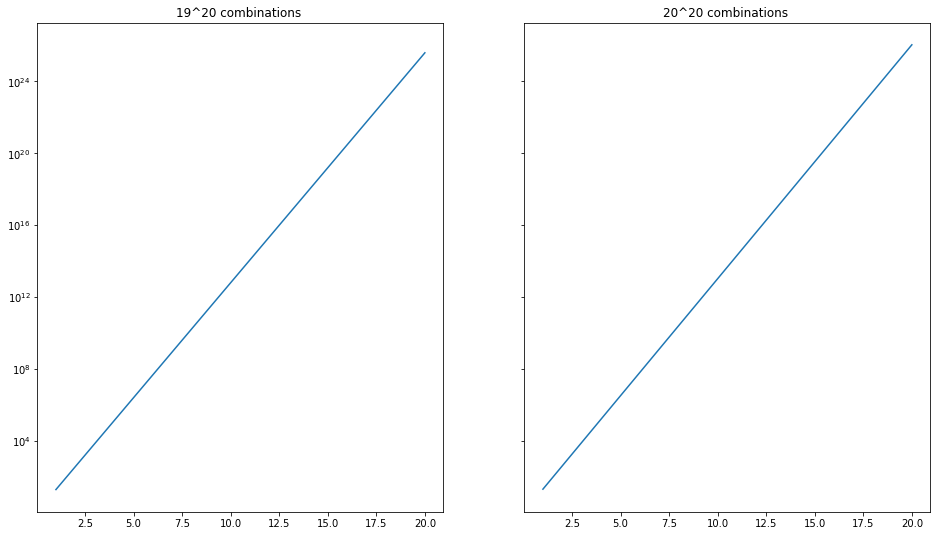

In [53]:
import matplotlib.pyplot as plt

## Generating 3^20 combinations 
data_points1 = []
index1 = []

for i in range(1,21): 
    data_points1.append(19**i)
    index1.append(i)
    
## Generating 2^20 combinations 
data_points2 = []
index2 = []
for i in range(1,21): 
    data_points2.append(20**i)
    index2.append(i)

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,9))

ax1.plot(index1, data_points1)
ax1.set_title('19^20 combinations ')
ax2.plot(index2,data_points2)
ax2.set_title('20^20 combinations ')
plt.yscale("log")